# Predicting Melbourne House Prices

### Project Objective

The objective of this project is to create a predictive model that estimates price of based on geological characteristics.

### Data Source 

The dataset used for this project is sourced from Kaggle's Melbourne Housing Market. It includes data points such as property type, number of bedrooms, land size, building area, and more, providing a rich foundation for predicting house prices using a linear regression model. The dataset is available at the following link:

https://www.kaggle.com/datasets/anthonypino/melbourne-housing-market

### Importing Libraries and Loading Dataset

In [244]:
# Data manipulation and analysis
import pandas as pd  
import numpy as np  

# Data visualization
import matplotlib.pyplot as plt  
import seaborn as sns   
import plotly.express as px

# Machine learning
from sklearn.model_selection import train_test_split  # Splitting data into training and testing sets
from sklearn.linear_model import LinearRegression, Ridge    # Linear Regression model
from sklearn.metrics import mean_squared_error, r2_score  # Evaluation metrics for regression models

In [245]:
df = pd.read_csv("melb_data.csv")
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.000,S,Biggin,3/12/2016,2.500,3067.000,...,1.000,1.000,202.000,NaN,NaN,Yarra,-37.800,144.998,Northern Metropolitan,4019.000
1,Abbotsford,25 Bloomburg St,2,h,1035000.000,S,Biggin,4/02/2016,2.500,3067.000,...,1.000,0.000,156.000,79.000,1900.000,Yarra,-37.808,144.993,Northern Metropolitan,4019.000
2,Abbotsford,5 Charles St,3,h,1465000.000,SP,Biggin,4/03/2017,2.500,3067.000,...,2.000,0.000,134.000,150.000,1900.000,Yarra,-37.809,144.994,Northern Metropolitan,4019.000
3,Abbotsford,40 Federation La,3,h,850000.000,PI,Biggin,4/03/2017,2.500,3067.000,...,2.000,1.000,94.000,NaN,NaN,Yarra,-37.797,144.997,Northern Metropolitan,4019.000
4,Abbotsford,55a Park St,4,h,1600000.000,VB,Nelson,4/06/2016,2.500,3067.000,...,1.000,2.000,120.000,142.000,2014.000,Yarra,-37.807,144.994,Northern Metropolitan,4019.000


### Data Exploration

In [246]:
df.shape

(13580, 21)

* The dataset contains 13580 rows and 21 columns, representing the dimensions of the data.

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

### Data Cleaning

In [248]:
# clearing outliers in Building area by taking out the top 5 percent and lower 5 percent
low, high = df["BuildingArea"].quantile([0.05, 0.95])
mask_area = df["BuildingArea"].between(low, high)
df = df[mask_area]

In [249]:
# Drop low and high cardinality categorical variables
df.drop(columns=["Method", "Type", "Address", "SellerG", "Date", "CouncilArea", "Regionname"], inplace=True)


In [250]:
# Drop Leaky Data
df.drop(columns=["YearBuilt", "Car", "Bathroom", "Bedroom2", "Postcode", "Distance", "Propertycount", "Landsize"], inplace=True)

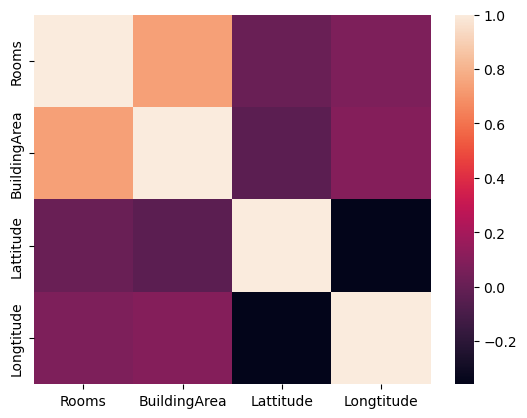

In [251]:
# Multicolinearity in table
corr = df.select_dtypes("number").drop(columns="Price").corr()
sns.heatmap(corr);

Multicollinearity is observed between the "Rooms" and "BuildingArea" columns. the 'Rooms' column is removed from the dataset, as its information is highly correlated with the 'BuildingArea' feature.

In [252]:
# drop column with multicolinearity
df.drop(columns=["Rooms"], inplace=True)

### Explore

In [253]:
# Checking Null values
missing_values = df.isnull().sum()
print(missing_values)

Suburb          0
Price           0
BuildingArea    0
Lattitude       0
Longtitude      0
dtype: int64


No null value in cleaned dataset

In [254]:
df["BuildingArea"].describe()

count   6441.000
mean     135.654
std       53.388
min       51.000
25%       96.000
50%      125.000
75%      167.000
max      294.000
Name: BuildingArea, dtype: float64

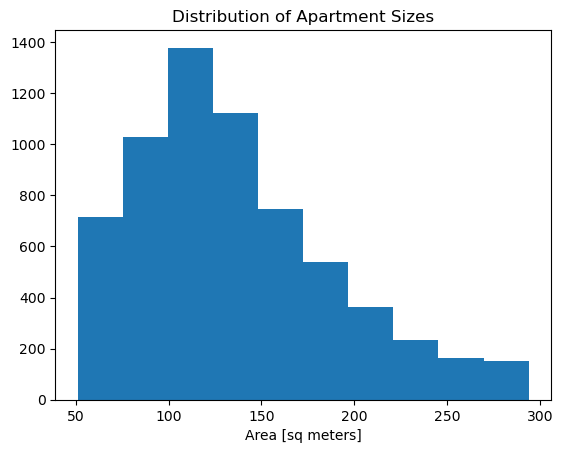

In [255]:
plt.hist(df["BuildingArea"], bins=10)
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartment Sizes");

In [256]:
df["Price"].describe()

count      6441.000
mean    1042786.489
std      578866.819
min      131000.000
25%      641000.000
50%      890000.000
75%     1300000.000
max     9000000.000
Name: Price, dtype: float64

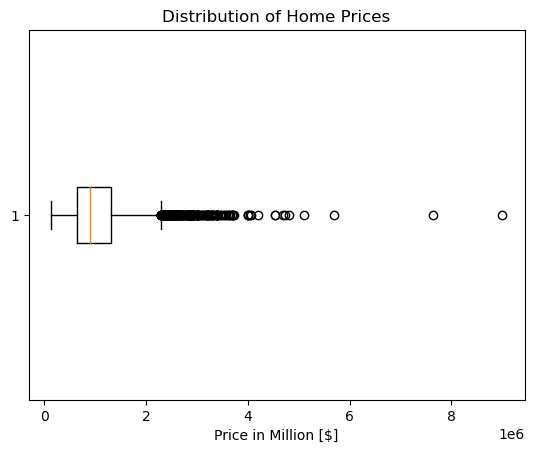

In [257]:
# Visualizing the outlier using boxplot
plt.boxplot(df["Price"], vert = False)
plt.xlabel("Price in Million [$]")
plt.title("Distribution of Home Prices");

Too many out liers in the price

In [258]:
# Removing outlier from prices
Q1 = df["Price"].quantile(0.25)
Q3 = df["Price"].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to exclude outliers
df = df[(df["Price"] >= lower_bound) & (df["Price"] <= upper_bound)]


In [259]:
# price description 
df["Price"].describe()

count      6201.000
mean     971795.239
std      437283.958
min      131000.000
25%      631000.000
50%      865000.000
75%     1250000.000
max     2286000.000
Name: Price, dtype: float64

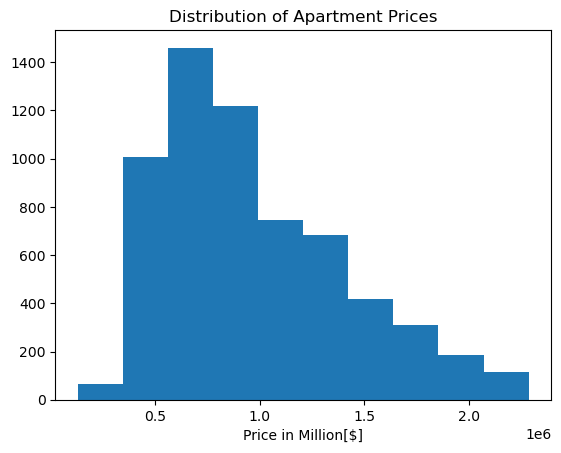

In [260]:
# Histogram of price  distribution
plt.hist(df["Price"], bins=10)
plt.xlabel("Price in Million[$]")
plt.title("Distribution of Apartment Prices");

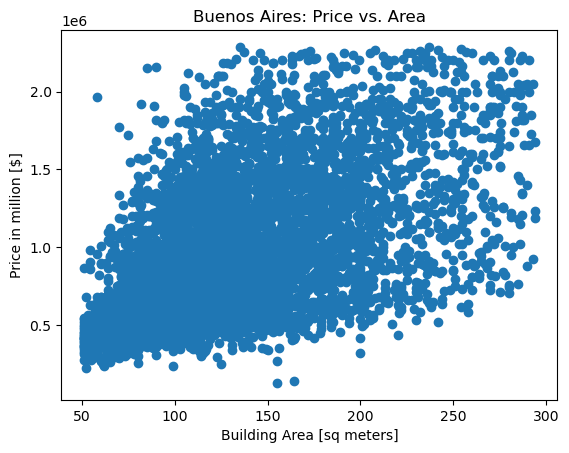

In [261]:
plt.scatter(x=df["BuildingArea"], y = df["Price"])
plt.xlabel("Building Area [sq meters]")
plt.ylabel("Price in million [$]")
plt.title("Buenos Aires: Price vs. Area");

Observation: High corelation between Building area and Price

In [262]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat="Lattitude",
    lon="Longtitude",
    width=600,  # Width of map
    height=600,  # Height of map
    color="Price",
    hover_data=["Price"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")
fig.show()

Observation: The central part of Melbourne exhibits higher house pricing compared to the outer areas

### Split Data

In [263]:
target = "Price"
features = ["BuildingArea", "Lattitude", "Longtitude", "Suburb"]
X = df[features]
y = df[target]

In [264]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 123)

In [265]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(4960, 4)
(4960,)
(1241, 4)
(1241,)


### Build Model

In [266]:
# Creating a pipeline named model that contains a OneHotEncoder and Ridge predictor
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)
# fitting model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Suburb'], use_cat_names=True)),
                ('ridge', Ridge())])

### Evaluation

In [267]:
# Make predictions on the training data
y_pred_train = model.predict(X_train)

# Evaluate the model
mse = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print(f"Training (MAE): {mse}")
print(f"Training (R2) Score: {r2}")

Training (MAE): 198225.20510251808
Training (R2) Score: 0.6525868074417643


In [271]:
# Make predictions on the training data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Testing (MAE): {mse}")
print(f"Testing (R2) Score: {r2}")

Testing (MAE): 207318.38352504798
Testing (R2) Score: 0.628644732471752


The model is performing well on testing data

# Communicating Results

In [272]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("intercept: ", intercept)
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

intercept:  -44342256.58088369
coefficients len: 292
[   5289.82147464 -473283.22222142  183499.36436802  281110.72200128
  423948.02397756]


### Creating function 

Creating a function make_prediction that takes four agruments(building_area, latitude, longitude, and suburb) and returns model's prediction for an apartment price

In [273]:
def make_prediction(BuildingArea, Lattitude, Longtitude, Suburb):
    data ={
        "BuildingArea": BuildingArea,
        "Lattitude": Lattitude,
        "Longtitude": Longtitude,
        "Suburb": Suburb
    }
    df=pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [274]:
# testing the function
make_prediction(110, -37.800, 144.998, "Abbotsford")

'Predicted apartment price: $1094691.94'

### Creating Interactive Model

In [275]:
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact, widgets
interact(
    make_prediction,
    BuildingArea=IntSlider(
        min=X_train["BuildingArea"].min(),
        max=X_train["BuildingArea"].max(),
        value=X_train["BuildingArea"].mean(),
    ),
    Lattitude=FloatSlider(
        min=X_train["Lattitude"].min(),
        max=X_train["Lattitude"].max(),
        step=0.01,
        value=X_train["Lattitude"].mean(),
    ),
    Longtitude=FloatSlider(
        min=X_train["Longtitude"].min(),
        max=X_train["Longtitude"].max(),
        step=0.01,
        value=X_train["Longtitude"].mean(),
    ),
    Suburb=Dropdown(options=sorted(X_train["Suburb"].unique())),
);

interactive(children=(IntSlider(value=132, description='BuildingArea', max=294, min=51), FloatSlider(value=-37…